In [1]:
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import keras
print(keras.__version__)

2.15.0


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.image import imread

In [4]:
# # Set TPU strategy
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [5]:
path = "Dataset"
os.listdir(path)

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___healthy',
 'Cherry___Powdery_mildew',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___healthy',
 'Corn___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 '

In [6]:
# Create an instance of ImageDataGenerator for normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an instance of ImageDataGenerator for normalization for testing
test_datagen = ImageDataGenerator(rescale=1./255)

input_size = (224,224)

# Set the batch size
batch_size = 64

In [7]:
# List all subdirectories in the given path
subdirectories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Create lists to store filenames and labels
filenames = []
labels = []

# Iterate through each subdirectory
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(path, subdirectory)

    # List all files in the subdirectory
    image_files = [f for f in os.listdir(subdirectory_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Append filenames and labels to the lists
    filenames.extend([os.path.join(subdirectory, file) for file in image_files])
    labels.extend([subdirectory] * len(image_files))

# Convert lists to numpy arrays
filenames = np.array(filenames)
labels = np.array(labels)

In [8]:
len(np.unique(labels))

39

In [9]:
# Calculate statistics
total_samples = len(labels)
unique_labels, class_counts = np.unique(labels, return_counts=True)
average_samples_per_class = total_samples / len(unique_labels)
min_samples_in_class = min(class_counts)
max_samples_in_class = max(class_counts)

# Print statistics
print("Total Samples:", total_samples)
print("Average Samples per Class:", average_samples_per_class)
print("Min Samples in a Class:", min_samples_in_class)
print("Max Samples in a Class:", max_samples_in_class)

Total Samples: 61486
Average Samples per Class: 1576.5641025641025
Min Samples in a Class: 1000
Max Samples in a Class: 5507


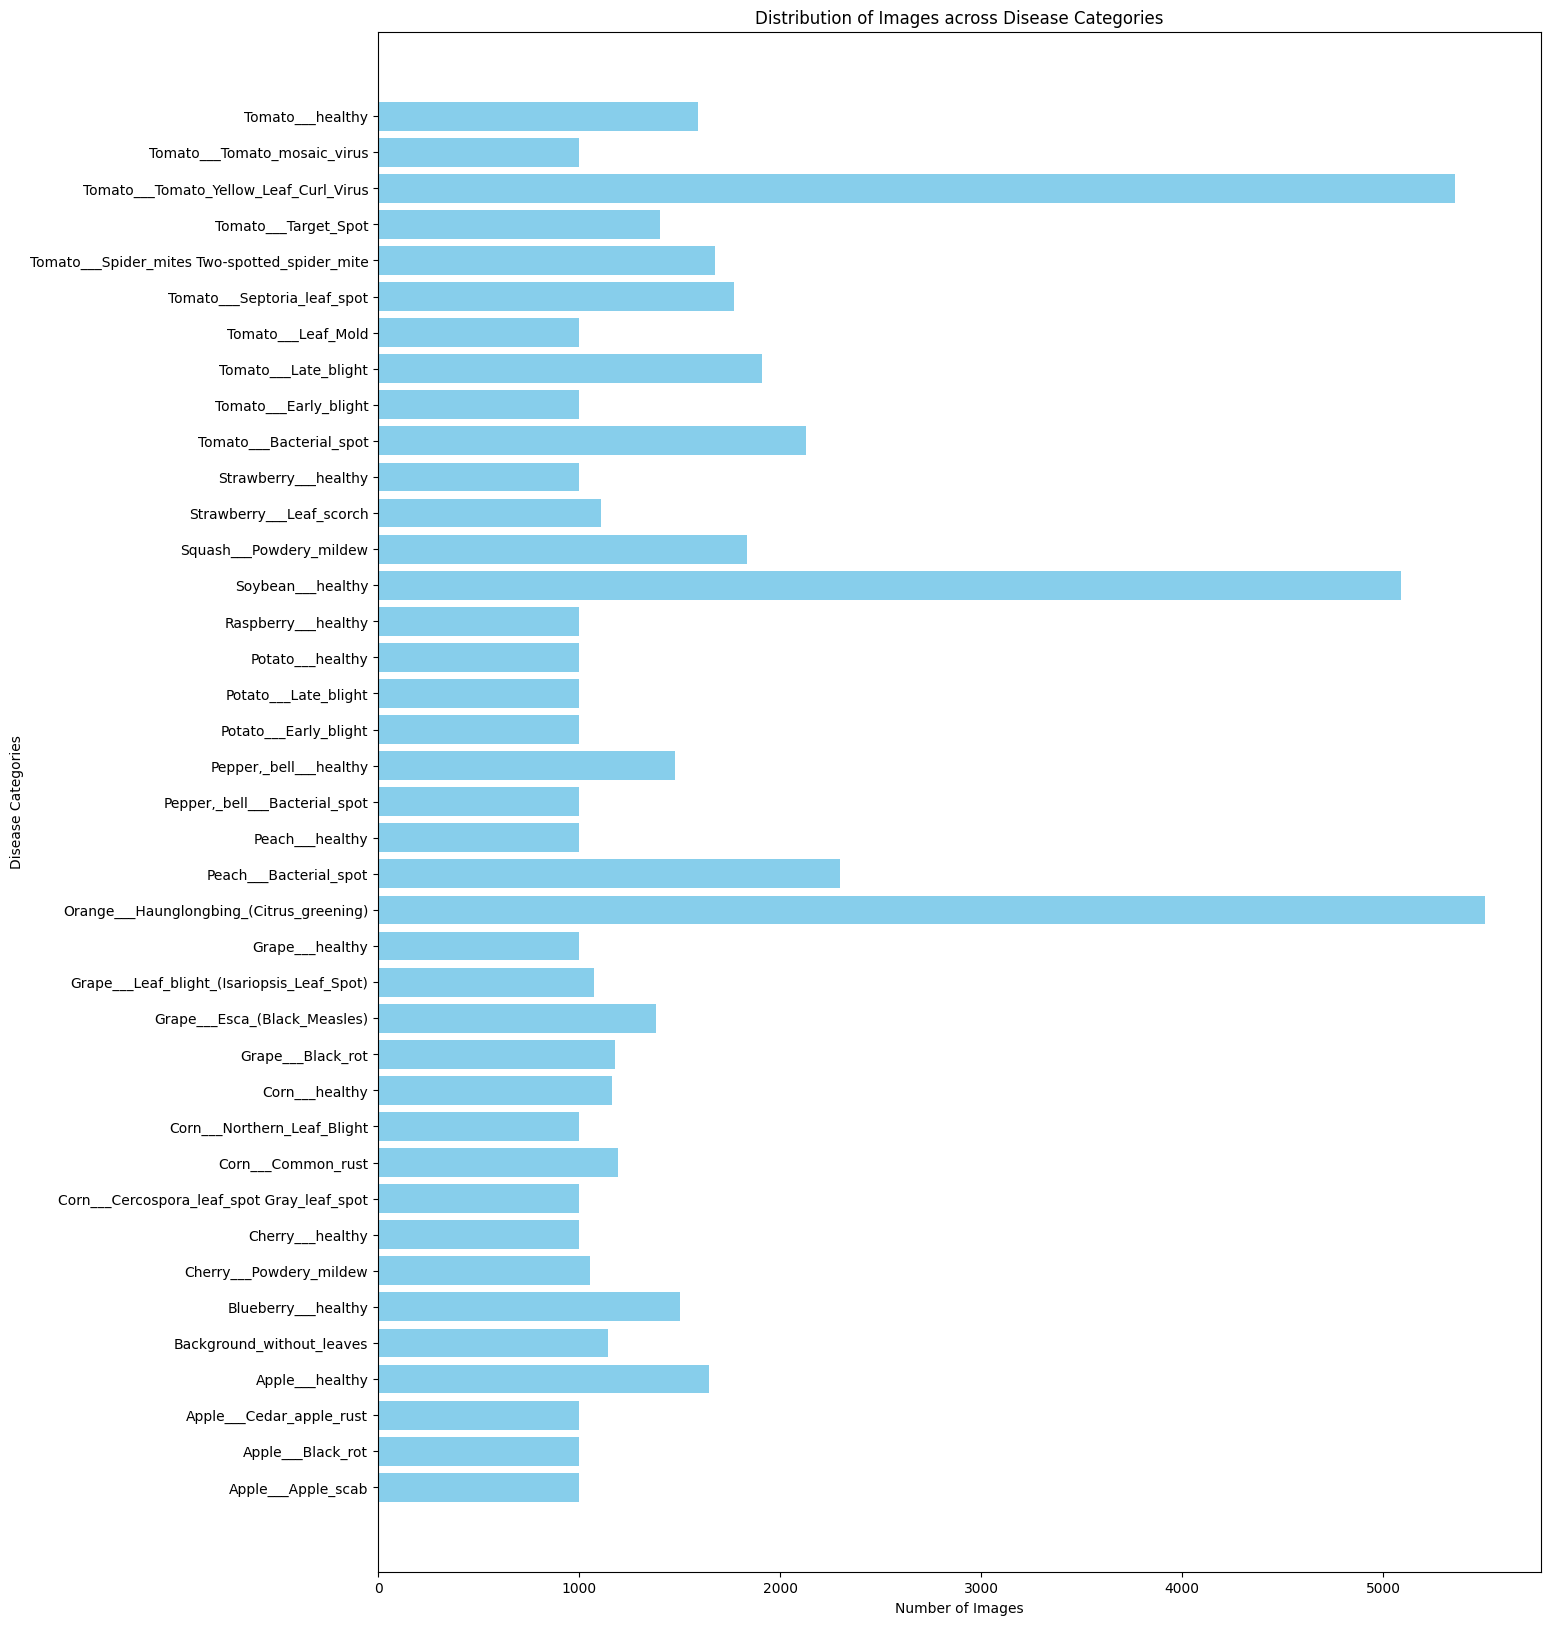

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Count the occurrences of each label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Set the size of the plot
plt.figure(figsize=(15, 20))  # Adjust the figure size accordingly

# Plot the horizontal bar chart
plt.barh(unique_labels, label_counts, color='skyblue')  # You can customize the color if needed
plt.xlabel('Number of Images')
plt.ylabel('Disease Categories')
plt.title('Distribution of Images across Disease Categories')

# Show the plot
plt.show()


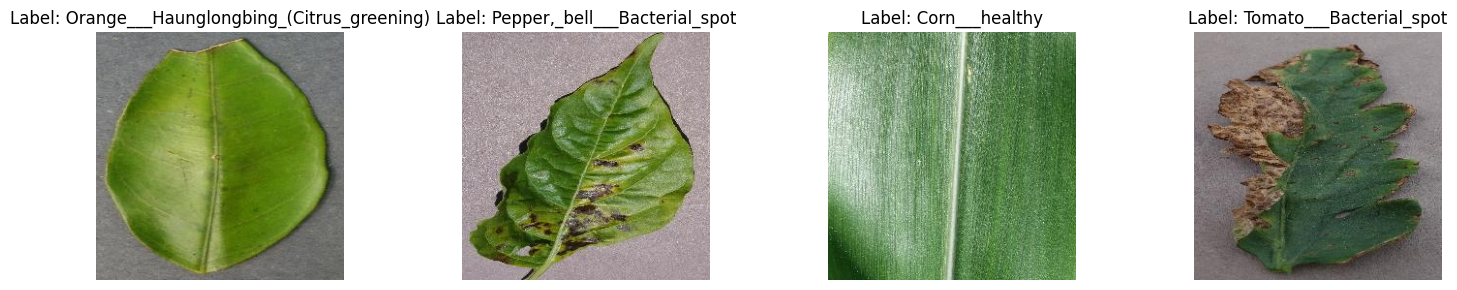

In [11]:
# Display a few images along with their labels in the same row
num_images_to_display = 4  # Change this to the desired number of images
selected_indices = np.random.choice(len(filenames), num_images_to_display, replace=False)

# Set up the subplots
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i, index in enumerate(selected_indices):
    image_path = os.path.join(path, filenames[index])
    label = labels[index]

    # Load and display the image using PIL
    img = Image.open(image_path)
    
    # You can optionally resize the image if needed
    # img = img.resize((width, height))

    # Display the image on the corresponding subplot
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()

In [12]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
numerical_labels = label_encoder.fit_transform(labels)

In [13]:
np.unique(numerical_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int64)

In [14]:
# Split your data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(filenames, numerical_labels, test_size=0.1, random_state=42, stratify=numerical_labels)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert string labels to integers for all sets
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [15]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [16]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [17]:
# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': x_train, 'class': y_train}),
    directory=path,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for numerical labels
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': x_val, 'class': y_val}),
    directory=path,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for numerical labels
    shuffle=False  # No shuffling for validation
)

test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': x_test, 'class': y_test}),
    directory=path,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for numerical labels
    shuffle=False  # No shuffling for testing
)

Found 55337 validated image filenames.
Found 3074 validated image filenames.
Found 3075 validated image filenames.


## DenseNet Model 

In [18]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import pandas as pd
import numpy as np

# Build DenseNet model
densenet = DenseNet121(weights='imagenet', include_top=False)

input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)

x = densenet(x)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Add another Dense layer
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Multi output
output = Dense(88, activation='softmax', name='root')(x)

# Model
model = Model(input, output)

# Using ExponentialDecay for learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024   7037504   
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                           

In [19]:
# from sklearn.utils.class_weight import compute_class_weight
# from tabulate import tabulate

# # Get unique class labels from your DataFrame
# unique_classes = np.unique(y_train)

# # Calculate class weights using unique class labels
# class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)

# # Convert to dictionary
# class_weight_dict = dict(zip(unique_classes, class_weights))

# # Print class weights in a table
# table = tabulate(class_weight_dict.items(), headers=['Class', 'Weight'], tablefmt='pretty')
# print(table)

In [20]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Build and train the model
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', verbose=1, save_best_only=True)

# Fits the model on batches with real-time data augmentatio
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    callbacks=[annealer, checkpoint],
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
#     class_weight=class_weight_dict  # Pass the class weights here
)

Epoch 1/30

1113/1113 [==============================] - ETA: 0s - loss: 1.5861 - accuracy: 0.5873

Epoch 1: val_loss improved from inf to 0.81748, saving model to /kaggle/working/model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


1113/1113 [==============================] - 2086s 2s/step - loss: 1.5861 - accuracy: 0.5873 - val_loss: 0.8175 - val_accuracy: 0.7334 - lr: 9.0000e-04

Epoch 2/30

1113/1113 [==============================] - ETA: 0s - loss: 0.6365 - accuracy: 0.8052

Epoch 2: val_loss improved from 0.81748 to 0.57859, saving model to /kaggle/working/model.h5

1113/1113 [==============================] - 1615s 1s/step - loss: 0.6365 - accuracy: 0.8052 - val_loss: 0.5786 - val_accuracy: 0.8278 - lr: 8.1000e-04

Epoch 3/30

1113/1113 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.8516

Epoch 3: val_loss improved from 0.57859 to 0.36301, saving model to /kaggle/working/model.h5

1113/1113 [==============================] - 1573s 1s/step - loss: 0.4764 - accuracy: 0.8516 - val_loss: 0.3630 - val_accuracy: 0.8806 - lr: 7.2900e-04

Epoch 4/30

1113/1113 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.8773

Epoch 4: val_loss did not improve from 0.36301

1113/

## Plotting the history

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Visualizing the predictions

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions on the test set
predictions_test = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels_test = np.argmax(predictions_test, axis=1)

# Get true labels
true_labels_test = test_generator.labels

# Compute confusion matrix for the test set
cm_test = confusion_matrix(true_labels_test, predicted_labels_test)

# Plot the heatmap
plt.figure(figsize=(20, 18))  # Increase the figure size
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(88), yticklabels=np.arange(88))
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("Classification Report - Test Set:")
report = classification_report(true_labels_test, predicted_labels_test, target_names=[str(i) for i in range(88)])
print(report)